### 1. Import Dependencies

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import metrics

### 2. Data preprocessing

In [10]:
df = pd.read_csv('imdb_top_movies.csv')

In [11]:
df.head()

,title,release_year,parental_rating,movie_duration,movie_rating,description,genres,budget,gross_na,gross_worldwide
0,The Lives of Others,2006,R,2h 17m,8.4,"In 1984 East Berlin, an agent of the secret po...","Drama,Mystery,Thriller","$2,000,000 (estimated)","$11,286,112","$77,357,476"
1,Sunset Blvd.,1950,Approved,1h 50m,8.4,A screenwriter develops a dangerous relationsh...,"Drama,Film-Noir","$1,752,000 (estimated)","$299,645","$304,474"
2,Raiders of the Lost Ark,1981,PG,1h 55m,8.4,"In 1936, archaeologist and adventurer Indiana ...","Action,Adventure","$18,000,000 (estimated)","$248,159,971","$389,925,971"
3,Memento,2000,R,1h 53m,8.4,A man with short-term memory loss attempts to ...,"Mystery,Thriller","$9,000,000 (estimated)","$25,544,867","$40,047,236"
4,WALL·E,2008,G,1h 38m,8.4,"In the distant future, a small waste-collectin...","Animation,Adventure,Family","$180,000,000 (estimated)","$223,808,164","$521,320,168"


In [12]:
predictors = ['release_year', 'movie_duration', 'budget', 'gross_worldwide']

In [13]:
df.describe()

,release_year,movie_rating
count,245.000000,245.000000
mean,1987.118367,8.306122
std,25.424717,0.232950
min,1921.000000,8.000000
25%,1968.000000,8.100000
50%,1995.000000,8.200000
75%,2007.000000,8.400000
max,2024.000000,9.300000


In [14]:
df.isnull().sum()

title              0
release_year       0
parental_rating    0
movie_duration     0
movie_rating       0
description        0
genres             0
budget             0
gross_na           0
gross_worldwide    0
dtype: int64

#### Process Numerical Data

In [15]:
df.movie_duration.unique()

array(['2h 17m', '1h 50m', '1h 55m', '1h 53m', '1h 38m', '1h 28m',
       '2h 22m', '2h 45m', '2h 27m', '2h 46m', '1h 27m', '2h 43m',
       '3h 1m', '1h 57m', '2h 54m', '1h 52m', '1h 30m', '1h 45m', '2h 7m',
       '1h 26m', '2h 26m', '2h 10m', '2h 9m', '1h 39m', '2h 34m',
       '1h 41m', '2h 1m', '2h 52m', '2h 28m', '1h 29m', '2h 25m',
       '1h 33m', '1h 42m', '2h 3m', '1h 54m', '2h 23m', '2h 2m', '2h 50m',
       '1h 20m', '2h', '1h 47m', '1h 36m', '1h 58m', '2h 4m', '1h 51m',
       '1h 32m', '2h 16m', '2h 32m', '1h 31m', '45m', '2h 11m', '1h 48m',
       '3h 3m', '1h 18m', '2h 8m', '2h 13m', '1h 35m', '2h 12m', '2h 19m',
       '3h 5m', '3h 32m', '2h 29m', '2h 14m', '1h 56m', '2h 20m',
       '2h 21m', '2h 41m', '3h 58m', '2h 33m', '1h 40m', '1h 59m',
       '2h 6m', '1h 49m', '2h 15m', '2h 38m', '2h 58m', '2h 18m',
       '1h 37m', '1h 8m', '1h 43m', '2h 59m', '2h 40m', '3h', '2h 36m',
       '2h 42m', '3h 38m', '2h 5m', '3h 49m', '1h 21m', '2h 44m',
       '1h 46m', '2h 31m',

In [16]:
# Converts movie duration to minutes
def duration_to_min(duration):
    hours = 0
    minutes = 0
    
    if 'h' in duration:
        h_idx = duration.index('h')
        hours = int(duration[0:h_idx])
        if 'm' in duration:
            m_idx = duration.index('m')
            minutes = int(duration[duration.index(' ')+1:m_idx])
    elif 'm' in duration:
        minutes = int(duration.strip('m'))
    return hours * 60 + minutes

In [17]:
df.movie_duration = df.movie_duration.apply(duration_to_min)

In [18]:
df.movie_duration

0      137
1      110
2      115
3      113
4       98
      ... 
240    195
241    175
242    202
243     96
244    152
Name: movie_duration, Length: 245, dtype: int64

In [19]:
# Start converting box office finance columns to numerical data
df['budget'] = df['budget'].str.replace('^\$| \(estimated\)|\,','', regex=True)
df['gross_worldwide'] = df['gross_worldwide'].str.replace('^\$| \(estimated\)|\,','', regex=True)

In [20]:
# Convert other currencies to USD
def stdize_currency(value):
    if '£' in value:
        return int(value.strip('£')) * 1.24
    elif '₩' in value:
        return int(value.strip('₩')) * 0.00073
    elif '€' in value:
        return int(value.strip('€')) * 1.07
    elif '¥' in value:
        return int(value.strip('¥')) * 0.0065
    elif 'FRF' in value:
        return int(value.strip('FRF ')) * 0.16
    elif 'A' in value:
        return int(value.strip('A$')) * 0.64
    elif 'R' in value:
        return int(value.strip('R$')) * 0.19
    elif 'DKK' in value:
        return int(value.strip('DKK ')) * 0.14
    elif '₹' in value:
        return int(value.strip('₹')) * 0.012
    elif 'DEM' in value:
        return int(value.strip('DEM ')) * 0.545039
    else:
        return int(value)

In [21]:
df['budget'] = df['budget'].apply(stdize_currency)
df['gross_worldwide'] = df['gross_worldwide'].apply(stdize_currency)

In [22]:
df.head()

,title,release_year,parental_rating,movie_duration,movie_rating,description,genres,budget,gross_na,gross_worldwide
0,The Lives of Others,2006,R,137,8.4,"In 1984 East Berlin, an agent of the secret po...","Drama,Mystery,Thriller",2000000.0,"$11,286,112",77357476
1,Sunset Blvd.,1950,Approved,110,8.4,A screenwriter develops a dangerous relationsh...,"Drama,Film-Noir",1752000.0,"$299,645",304474
2,Raiders of the Lost Ark,1981,PG,115,8.4,"In 1936, archaeologist and adventurer Indiana ...","Action,Adventure",18000000.0,"$248,159,971",389925971
3,Memento,2000,R,113,8.4,A man with short-term memory loss attempts to ...,"Mystery,Thriller",9000000.0,"$25,544,867",40047236
4,WALL·E,2008,G,98,8.4,"In the distant future, a small waste-collectin...","Animation,Adventure,Family",180000000.0,"$223,808,164",521320168


#### Process Textual Data

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samuelleung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
print(stopwords.words('english')[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [25]:
# Stemming words
port_stem = PorterStemmer()

In [26]:
def to_stem(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', str(content))
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if word not in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [27]:
df['description'] = df['description'].apply(to_stem)

In [28]:
df['description']

0      east berlin agent secret polic conduct surveil...
1      screenwrit develop danger relationship fade fi...
2      archaeologist adventur indiana jone hire u gov...
3      man short term memori loss attempt track wife ...
4      distant futur small wast collect robot inadver...
                             ...                        
240    german occupi poland world war ii industrialis...
241    age patriarch organ crime dynasti transfer con...
242    earli life career vito corleon new york citi p...
243    juri new york citi murder trial frustrat singl...
244    menac known joker wreak havoc chao peopl gotha...
Name: description, Length: 245, dtype: object

In [29]:
# Vectorization
vectorizer = TfidfVectorizer()
vec_mat = vectorizer.fit_transform(df['description'].values)
X_text = pd.DataFrame(vec_mat.todense(), columns=vectorizer.vocabulary_)
df = pd.concat([df,X_text], axis=1)
df.head()

,title,release_year,parental_rating,movie_duration,movie_rating,description,genres,budget,gross_na,gross_worldwide,...,jump,hasti,verdict,menac,havoc,accept,greatest,psycholog,test,abil
0,The Lives of Others,2006,R,137,8.4,east berlin agent secret polic conduct surveil...,"Drama,Mystery,Thriller",2000000.0,"$11,286,112",77357476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sunset Blvd.,1950,Approved,110,8.4,screenwrit develop danger relationship fade fi...,"Drama,Film-Noir",1752000.0,"$299,645",304474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Raiders of the Lost Ark,1981,PG,115,8.4,archaeologist adventur indiana jone hire u gov...,"Action,Adventure",18000000.0,"$248,159,971",389925971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Memento,2000,R,113,8.4,man short term memori loss attempt track wife ...,"Mystery,Thriller",9000000.0,"$25,544,867",40047236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,WALL·E,2008,G,98,8.4,distant futur small wast collect robot inadver...,"Animation,Adventure,Family",180000000.0,"$223,808,164",521320168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3. Data Analysis and Visualization

In [30]:
df.describe()

,release_year,movie_duration,movie_rating,budget,gross_worldwide,east,berlin,agent,secret,polic,...,jump,hasti,verdict,menac,havoc,accept,greatest,psycholog,test,abil
count,245.000000,245.000000,245.000000,2.450000e+02,2.450000e+02,245.000000,245.000000,245.000000,245.000000,245.000000,...,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000
mean,1987.118367,129.669388,8.306122,3.555258e+07,2.310160e+08,0.003325,0.001238,0.001043,0.001072,0.001276,...,0.015715,0.001283,0.001922,0.001059,0.001252,0.005904,0.001048,0.018819,0.001097,0.001834
std,25.424717,30.065381,0.232950,5.594338e+07,3.708871e+08,0.030742,0.019372,0.016324,0.016783,0.019979,...,0.059149,0.020081,0.021235,0.016579,0.019592,0.034573,0.016406,0.056515,0.017164,0.020322
min,1921.000000,45.000000,8.000000,3.990000e+02,1.260000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1968.000000,109.000000,8.100000,2.771300e+06,7.804803e+06,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1995.000000,127.000000,8.200000,1.300000e+07,6.579686e+07,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2007.000000,146.000000,8.400000,4.000000e+07,3.217527e+08,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024.000000,238.000000,9.300000,3.560000e+08,2.799439e+09,0.361328,0.303225,0.255514,0.262689,0.312721,...,0.416902,0.314318,0.235742,0.259503,0.306666,0.230901,0.256798,0.302682,0.268657,0.242144


In [31]:
df[['budget','gross_worldwide','movie_duration','movie_rating']].corr()

,budget,budget,gross_worldwide,movie_duration,movie_rating
budget,1.000000,0.212071,0.843242,0.175761,0.136492
budget,0.212071,1.000000,0.158257,0.006866,0.059134
gross_worldwide,0.843242,0.158257,1.000000,0.180541,0.183286
movie_duration,0.175761,0.006866,0.180541,1.000000,0.290768
movie_rating,0.136492,0.059134,0.183286,0.290768,1.000000


### 4. Split Data

In [32]:
X = pd.concat([df[predictors],X_text], axis=1)
y = df.movie_rating

In [33]:
X.head()

,release_year,movie_duration,budget,budget,gross_worldwide,east,berlin,agent,secret,polic,...,jump,hasti,verdict,menac,havoc,accept,greatest,psycholog,test,abil
0,2006,137,2000000.0,0.0,77357476,0.0,0.0,0.0,0.0,0.312721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1950,110,1752000.0,0.0,304474,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1981,115,18000000.0,0.0,389925971,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000,113,9000000.0,0.0,40047236,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2008,98,180000000.0,0.0,521320168,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=2)

In [35]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(220, 1895) (25, 1895) (220,) (25,)


### 5. Train Model

#### Lasso Regression

In [36]:
lasso_model = Lasso()

In [37]:
lasso_model.fit(X_train, y_train)

Lasso()

In [39]:
print('TRAIN')
train_preds = lasso_model.predict(X_train)
train_mse = metrics.mean_squared_error(y_train, train_preds)
train_r2 = metrics.r2_score(y_train, train_preds)
print('MSE: ', train_mse)
print('R squared error: ', train_r2)

print('\nTEST')
test_preds = lasso_model.predict(X_test)
test_mse = metrics.mean_squared_error(y_test, test_preds)
test_r2 = metrics.r2_score(y_test, test_preds)
print('MSE: ', test_mse)
print('R squared error: ', test_r2)

TRAIN
MSE:  0.049150133672093026
R squared error:  0.10230098955105016

TEST
MSE:  0.04931719272315177
R squared error:  -0.03921933418644041


- MSE indicates strong predictive accuracy
- However, r2_score suggests that models lack explanatory power
- May consider larger, more diverse dataset

Text(0, 0.5, 'Actual')

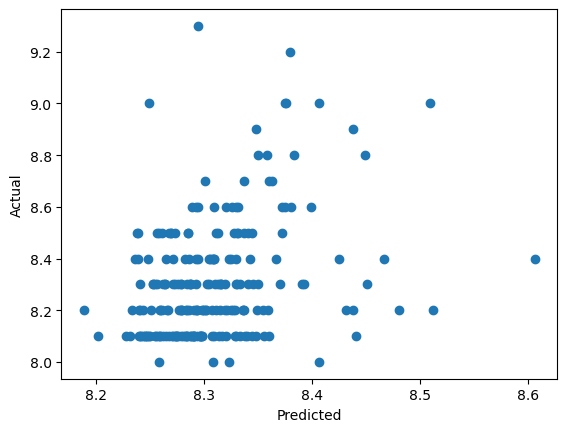

In [88]:
plt.scatter(train_preds, y_train)
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(0, 0.5, 'Actual')

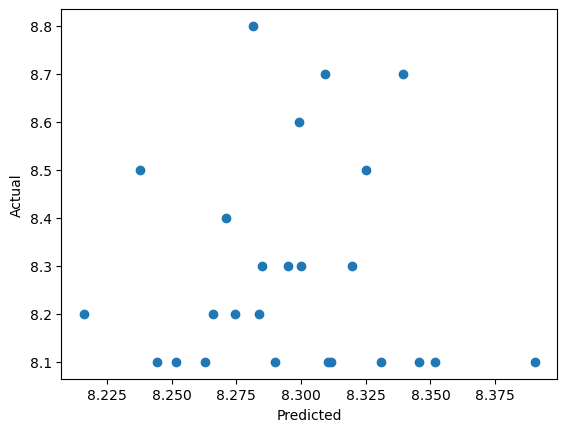

In [89]:
plt.scatter(test_preds, y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')